<a href="https://colab.research.google.com/github/alyilmaz99/language-detection/blob/main/language_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install wget

In [4]:
!pip install --upgrade scikit-learn

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, wget
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from wordcloud import WordCloud
wget.download("https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py",out="helper_prabowo_ml.py")


from helper_prabowo_ml import clean_html, remove_links, remove_special_characters, removeStopWords, remove_, remove_digits, lower, email_address, non_ascii, punct, hashtags
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
plt.rcParams['figure.figsize'] = (12,8)

In [7]:
df = pd.read_csv("/content/LanguageDetection.csv")
df = df.sample(frac=1)
df.head()

,Text,Language
9346,هل يمكنك أن تغطيني لقد حان وقت المغادرة ، ومن ...,Arabic
2517,Há muitas áreas de investigação em que novos e...,Portugeese
9078,بين محرري ويكيبيديا، غالبًا ما يتم التعبير عن ...,Arabic
9350,من الأفضل أن أذهب بطريقة أخرى لأقول وداعًا.,Arabic
863,[43] Reinforcement learning algorithms do not ...,English


In [8]:
df.duplicated().sum()
#Tekrarlı veriyi silme
df.drop_duplicates(inplace= True)
print(df)

                                                   Text    Language
9346  هل يمكنك أن تغطيني لقد حان وقت المغادرة ، ومن ...      Arabic
2517  Há muitas áreas de investigação em que novos e...  Portugeese
9078  بين محرري ويكيبيديا، غالبًا ما يتم التعبير عن ...      Arabic
9350        من الأفضل أن أذهب بطريقة أخرى لأقول وداعًا.      Arabic
863   [43] Reinforcement learning algorithms do not ...     English
...                                                 ...         ...
5122  [214]​[215]​ Por otro lado, en opinión de Césa...     Spanish
6592                              конечно, без проблем.     Russian
4779    Ze was helemaal verbaasd over hoe knap hij was.       Dutch
6275  Для построения таких методов используются сред...     Russian
2542  [27] A Wikipédia começou como um projeto compl...  Portugeese

[10271 rows x 2 columns]


In [9]:
df.shape

(10271, 2)

In [10]:
df.Language.unique()

array(['Arabic', 'Portugeese', 'English', 'French', 'Sweedish', 'Italian',
       'Malayalam', 'Russian', 'Spanish', 'Greek', 'Tamil', 'Turkish',
       'Dutch', 'Danish', 'German', 'Kannada', 'Hindi'], dtype=object)

In [11]:
df['Language'] = df['Language'].astype(str)


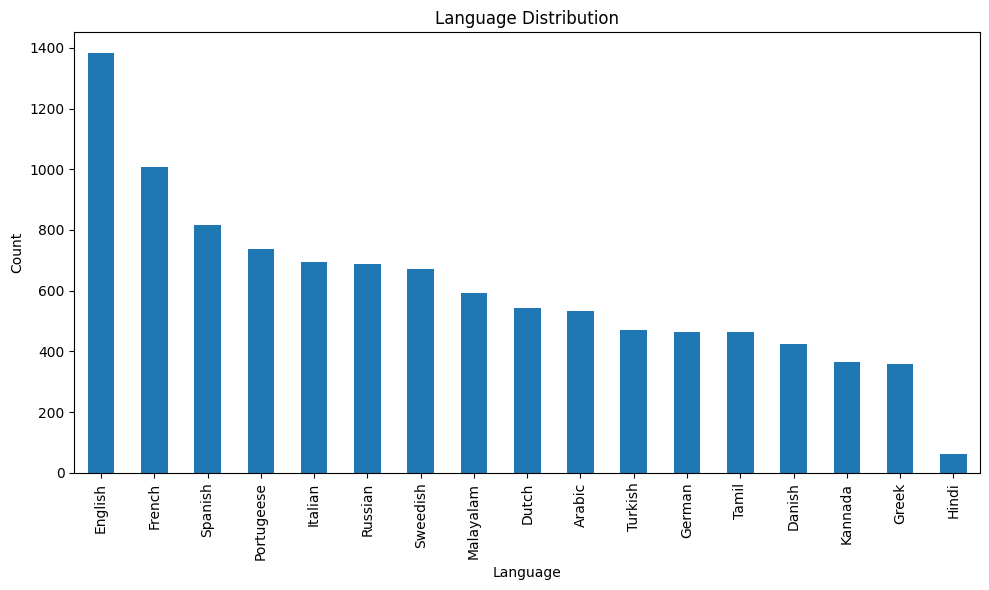

In [12]:
plt.figure(figsize=(10, 6))
df['Language'].value_counts().plot(kind='bar')
plt.xlabel('Language')
plt.ylabel('Count')
plt.title('Language Distribution')
plt.tight_layout()
plt.show()



In [13]:
df = df[df.Language.isin(["English","French","Dutch","Spanish","Danish","Italian","Swedish","German","Portuguese","Turkish"])]
df.shape

(5801, 2)

In [14]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5801 entries, 863 to 4779
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      5801 non-null   object
 1   Language  5801 non-null   object
dtypes: object(2)
memory usage: 136.0+ KB


In [53]:
#sns.countplot(df.Language);

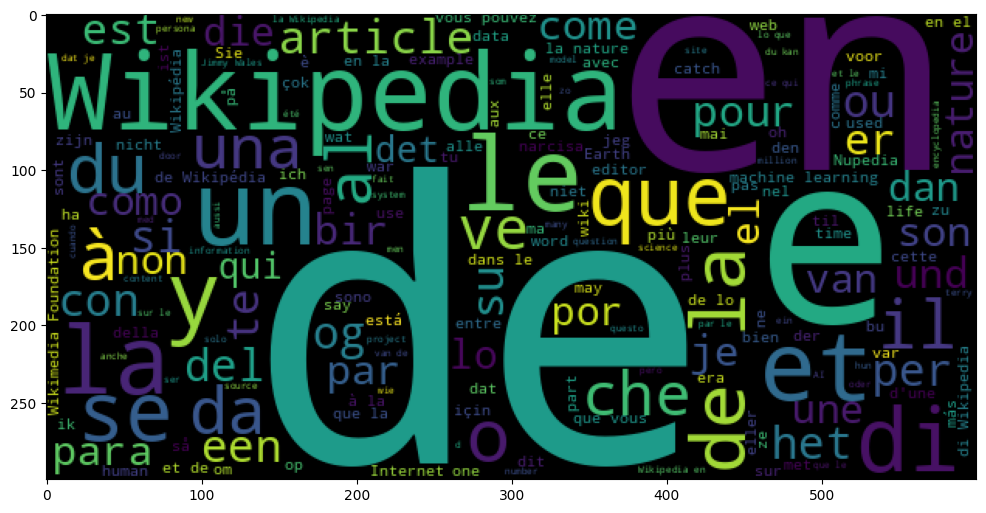

In [15]:
wc = WordCloud(width=600,height=300,random_state=42).generate(' '.join(df.Text))
plt.imshow(wc);

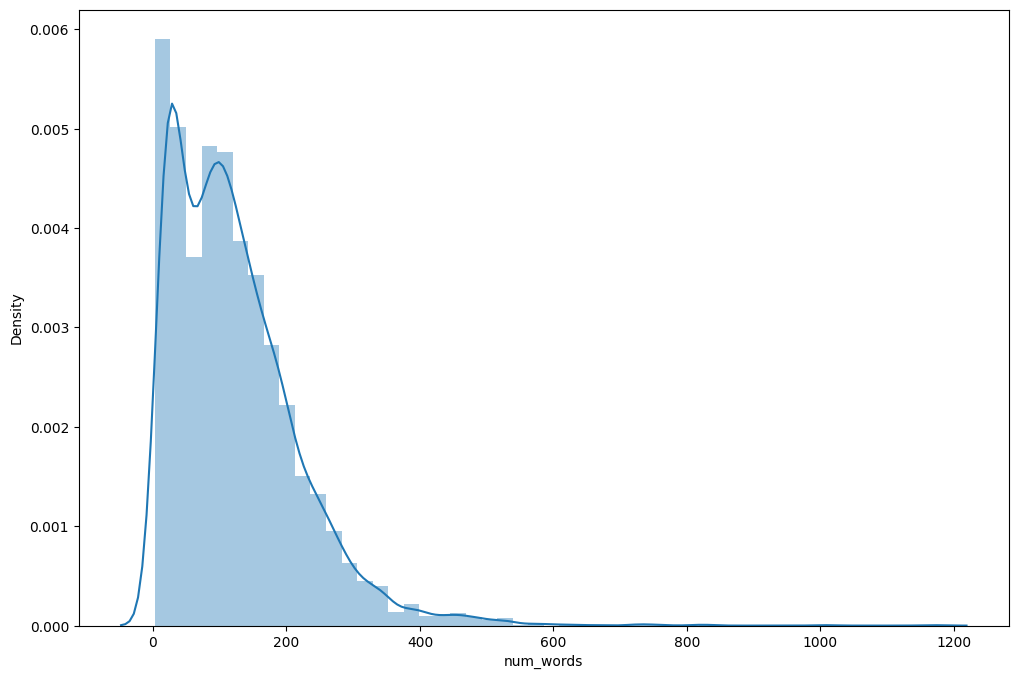

In [16]:
df['num_words'] = df.Text.apply(len)
sns.distplot(df.num_words);

In [17]:
df.num_words.describe()

count    5801.000000
mean      122.826754
std        95.737301
min         3.000000
25%        48.000000
50%       106.000000
75%       171.000000
max      1168.000000
Name: num_words, dtype: float64

In [18]:
max_len = 125

In [19]:
def text_preprocess(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=lower)
    return data

In [20]:
preprocessed_df = text_preprocess(df,'Text')
preprocessed_df.head()

,Text,Language,num_words
863,reinforcement learning algorithms assume knowl...,English,152
3499,il permet de lire un fichier au format zim con...,French,172
3800,cette rcompense normalement donne des personne...,French,188
7115,viene pubblicata fin dal novembre,Italian,45
7236,gli amministratori sysop sono pi numerosi oltr...,Italian,407


In [21]:
labels_dict = {}
for idx, lang in enumerate(preprocessed_df.Language.unique()):
    labels_dict[lang] = idx
labels_dict

{'English': 0,
 'French': 1,
 'Italian': 2,
 'Spanish': 3,
 'Turkish': 4,
 'Dutch': 5,
 'Danish': 6,
 'German': 7}

In [22]:
preprocessed_df['Label'] = preprocessed_df.Language.map(labels_dict)
preprocessed_df.head()

,Text,Language,num_words,Label
863,reinforcement learning algorithms assume knowl...,English,152,0
3499,il permet de lire un fichier au format zim con...,French,172,1
3800,cette rcompense normalement donne des personne...,French,188,1
7115,viene pubblicata fin dal novembre,Italian,45,2
7236,gli amministratori sysop sono pi numerosi oltr...,Italian,407,2


In [23]:
preprocessed_df.sample(frac=1)

,Text,Language,num_words,Label
1037,swamp piece wetland somebody steps wrong place...,English,181,0
8231,telaa gerek yok,Turkish,17,4
7990,hey arkadalar bu videoda kanalma ho geldiniz,Turkish,48,4
758,seen part artificial intelligence,English,52,0
1145,ll fine,English,13,0
...,...,...,...,...
1359,got ready bed mother really hope dream comes t...,English,159,0
5579,era un sueo muy egosta mam sabes lo que ests d...,Spanish,185,3
4753,omdat haar schoonheid wijd en zijd bekend was ...,Dutch,196,5
4865,por ejemplo wikinfo uno de los portales web re...,Spanish,121,3


In [24]:
train_df, test_df = train_test_split(preprocessed_df,test_size=0.3,random_state=42,shuffle=True,stratify=preprocessed_df.Language)

In [25]:
tokenizer = AutoTokenizer.from_pretrained("papluca/xlm-roberta-base-language-detection")
xlm = TFAutoModelForSequenceClassification.from_pretrained("papluca/xlm-roberta-base-language-detection",from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFXLMRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaForSequenceClassification for predictions without further training.


In [26]:
X_train = tokenizer(text=train_df.Text.tolist(),
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   add_special_tokens=True,
                   return_tensors="tf",
                   return_attention_mask=True,
                   return_token_type_ids=False,
                   verbose=True)

X_test = tokenizer(text=test_df.Text.tolist(),
                  max_length=max_len,
                  padding=True,
                  truncation=True,
                  add_special_tokens=True,
                  return_tensors="tf",
                  return_attention_mask=True,
                  return_token_type_ids=False,
                  verbose=True)

In [27]:
input_ids = Input(shape=(max_len,),dtype=tf.int32,name='input_ids')
attention_mask = Input(shape=(max_len,),dtype=tf.int32,name='attention_mask')

In [28]:
embeddings = xlm(input_ids,attention_mask=attention_mask)[0] # 0 --> final hidden state, 1 --> pooling output
output = Flatten()(embeddings)
output = Dense(units=1024,activation='relu')(output)
output = Dropout(0.3)(output)
output = Dense(units=512,activation='relu')(output)
output = Dropout(0.2)(output)
output = Dense(units=512,activation='relu')(output)
output = Dropout(0.2)(output)
output = Dense(units=128,activation='relu')(output)
output = Dense(units=8,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_mask],outputs=output)
model.layers[2].trainable = True

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 125)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 125)]                0         []                            
 )                                                                                                
                                                                                                  
 tfxlm_roberta_for_sequence  TFSequenceClassifierOutput   2780590   ['input_ids[0][0]',           
 _classification (TFXLMRobe  (loss=None, logits=(None,    28         'attention_mask[0][0]']      
 rtaForSequenceClassificati  20),                                                             

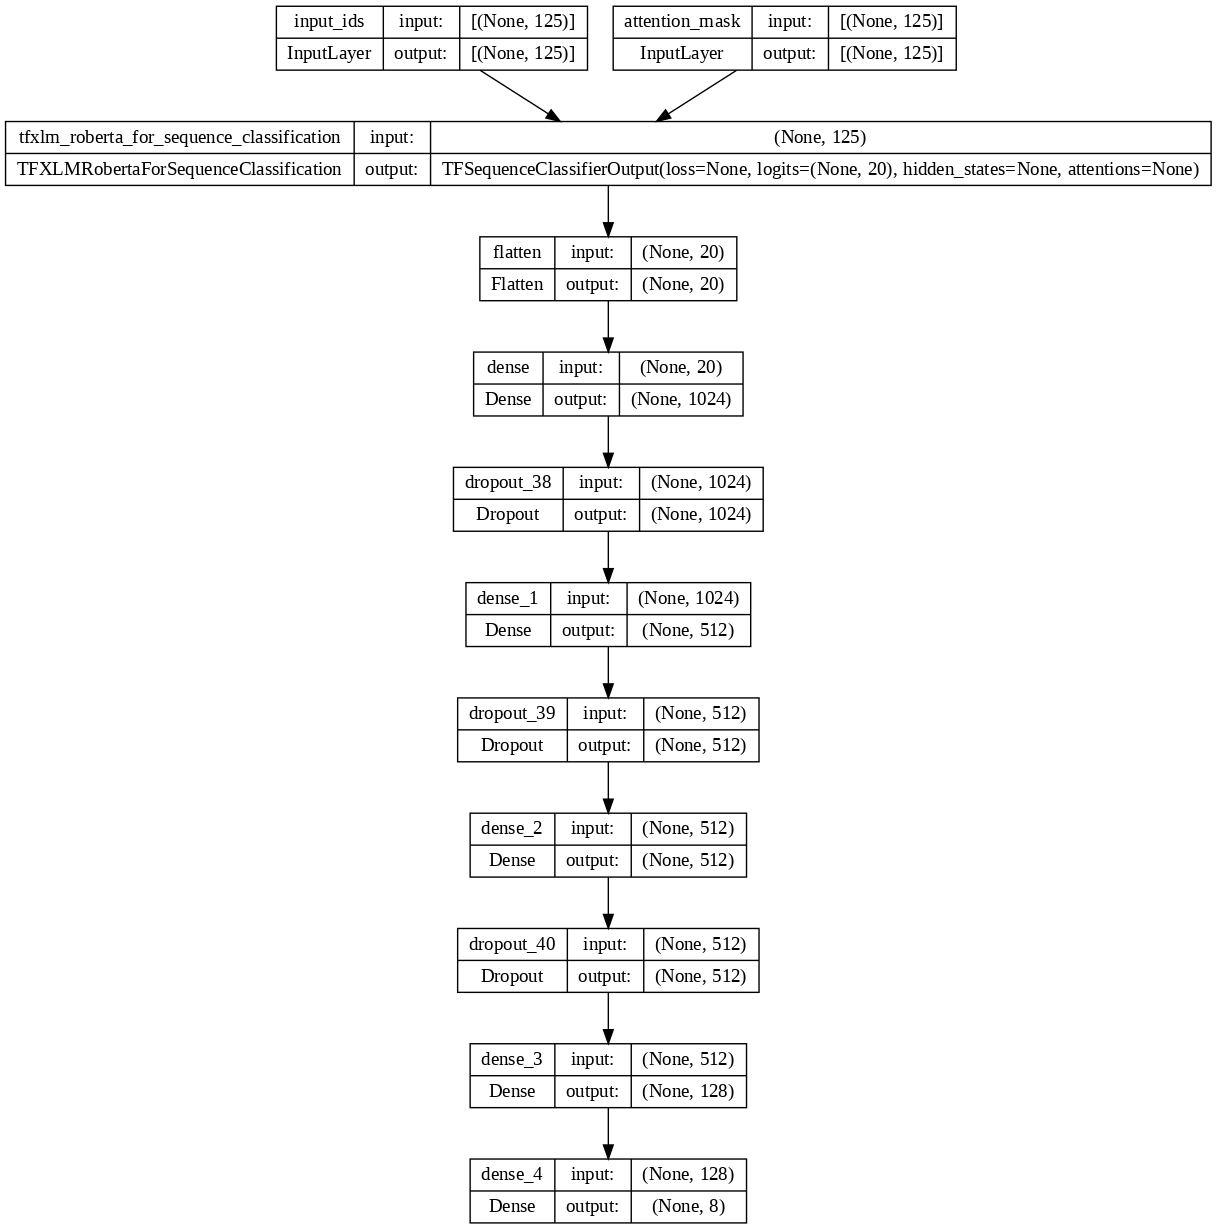

In [30]:
plot_model(model,'model.png',show_shapes=True,dpi=100,rankdir='TB')

In [31]:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy  # Import the metric

optimizer = Adam(learning_rate=5e-5, epsilon=2e-8, decay=0.01, clipnorm=1.0)
loss = CategoricalCrossentropy()
metrics = CategoricalAccuracy('balanced_accuracy')
model.compile(loss=loss, optimizer=optimizer, metrics=metrics,run_eagerly=True)

In [32]:
es = EarlyStopping(monitor='val_balanced_accuracy',patience=20,verbose=1,mode='max',restore_best_weights=True)
mc = ModelCheckpoint(filepath='checkpoint',monitor='val_balanced_accuracy',mode='max',save_best_only=True,verbose=1)

r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
              y=to_categorical(train_df.Label),
              epochs=20,
              batch_size=32,
              callbacks=[es,mc],
              validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_df.Label))
             )

Epoch 1/20
127/127 [==============================] - ETA: 0s - loss: 0.9192 - balanced_accuracy: 0.7665
Epoch 1: val_balanced_accuracy improved from -inf to 0.97358, saving model to checkpoint
127/127 [==============================] - 160s 1s/step - loss: 0.9192 - balanced_accuracy: 0.7665 - val_loss: 0.2242 - val_balanced_accuracy: 0.9736
Epoch 2/20
127/127 [==============================] - ETA: 0s - loss: 0.1743 - balanced_accuracy: 0.9665
Epoch 2: val_balanced_accuracy improved from 0.97358 to 0.98162, saving model to checkpoint
127/127 [==============================] - 159s 1s/step - loss: 0.1743 - balanced_accuracy: 0.9665 - val_loss: 0.0755 - val_balanced_accuracy: 0.9816
Epoch 3/20
127/127 [==============================] - ETA: 0s - loss: 0.0918 - balanced_accuracy: 0.9808
Epoch 3: val_balanced_accuracy improved from 0.98162 to 0.98219, saving model to checkpoint
127/127 [==============================] - 162s 1s/step - loss: 0.0918 - balanced_accuracy: 0.9808 - val_loss: 0

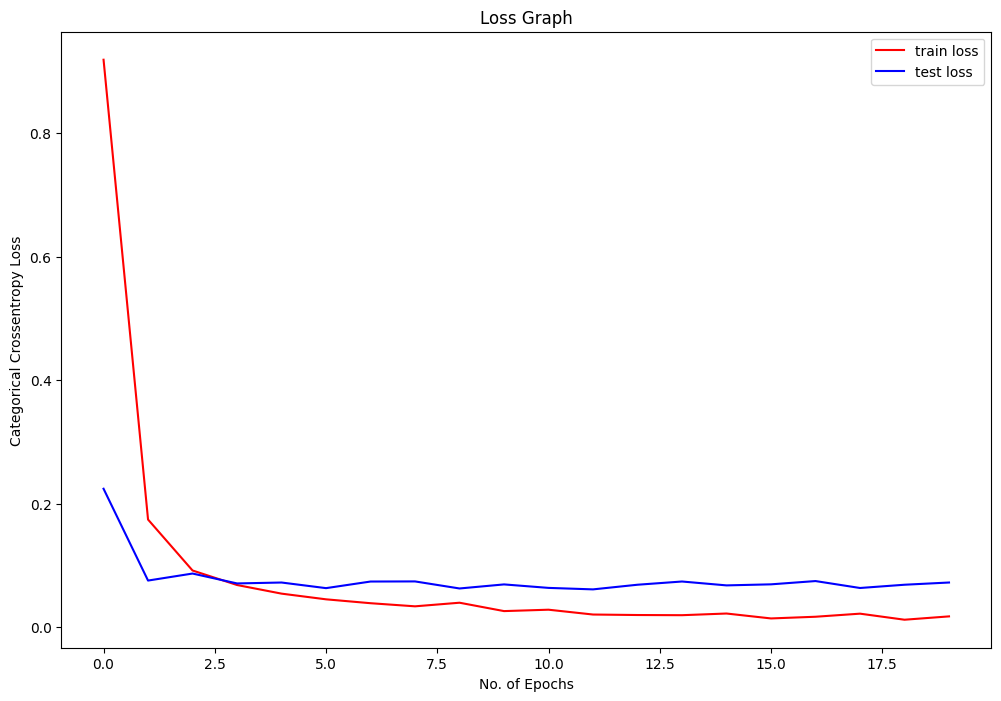

In [33]:
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Categorical Crossentropy Loss')
plt.title('Loss Graph')
plt.legend();

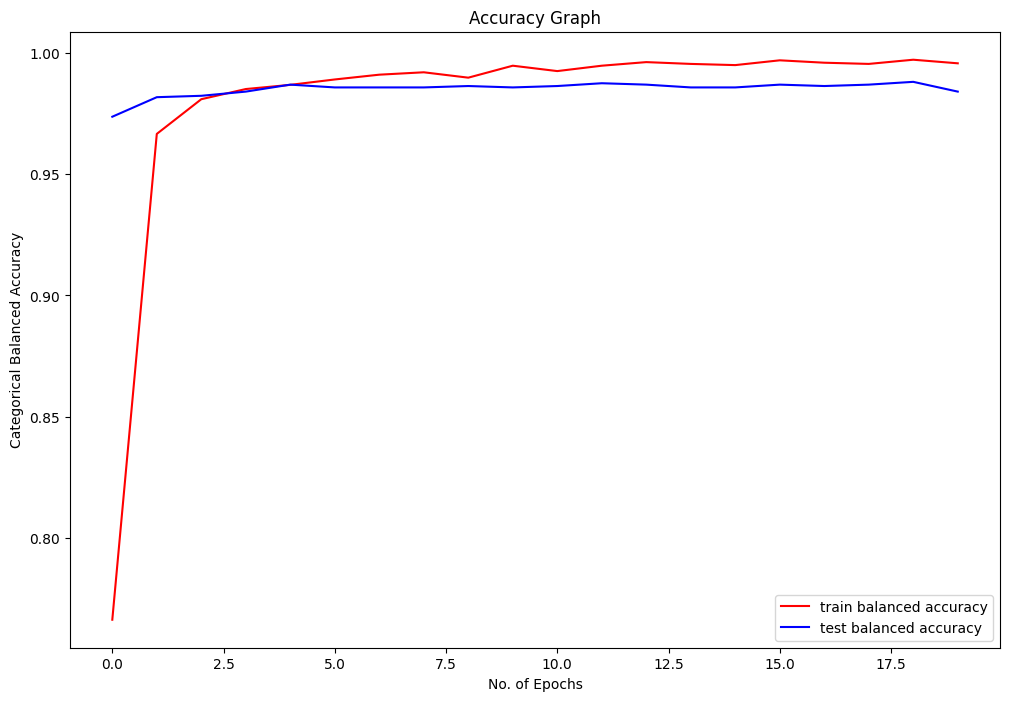

In [34]:
plt.plot(r.history['balanced_accuracy'],'r',label='train balanced accuracy')
plt.plot(r.history['val_balanced_accuracy'],'b',label='test balanced accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Categorical Balanced Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [35]:
model.save('language_detector2.h5')

In [36]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_df.Label))
print("Categorical Cross-entropy Loss:", loss)
print("Categorical Accuracy:", acc)

55/55 [==============================] - 11s 203ms/step - loss: 0.0723 - balanced_accuracy: 0.9839
Categorical Cross-entropy Loss: 0.0722830593585968
Categorical Accuracy: 0.9839172959327698


In [37]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print("Confusion Matrix:")
print(confusion_matrix(test_df.Label,test_predictions))
print('-----------------------------')
print("Encoded Labels:")
print(labels_dict)
print('-----------------------------')
print("Classification Report:")
print(classification_report(test_df.Label,test_predictions))

55/55 [==============================] - 11s 194ms/step
Confusion Matrix:
[[412   1   0   0   0   0   0   2]
 [  2 296   1   1   1   0   0   1]
 [  0   0 208   0   0   0   0   0]
 [  2   2   6 235   0   0   0   0]
 [  0   1   1   0 138   0   1   0]
 [  1   0   0   0   0 161   0   1]
 [  0   1   0   0   0   0 126   0]
 [  0   0   0   0   0   2   1 137]]
-----------------------------
Encoded Labels:
{'English': 0, 'French': 1, 'Italian': 2, 'Spanish': 3, 'Turkish': 4, 'Dutch': 5, 'Danish': 6, 'German': 7}
-----------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       415
           1       0.98      0.98      0.98       302
           2       0.96      1.00      0.98       208
           3       1.00      0.96      0.98       245
           4       0.99      0.98      0.99       141
           5       0.99      0.99      0.99       163
           6       0.98      0.99      0.99       127
     